# Data Wrangling WeRateDogs (Analyzing and Visualizing) Twitter Data

By Shimaa Elabd

Date: December 30, 2018

In This project I will wrangle the **WeRateDogs** Twitter data to create interesting and trustworthy analyses and visualizations. The challenge lies in the fact that the Twitter archive is great, but it only contains very basic tweet information that comes in JSON format. For a successful project, I needed to gather, asses and clean the Twitter data for a worthy analysis and visualization.

## Table of Contents
- [Introduction](#intro)
- [Part I - Gathering Data](#Gathering)
- [Part II - Assessing Data](#Assessing)
- [Part III - Cleaning Data](#Cleaning)
- [Part IV - Storing, Analyzing, and Visualizing Data ](#SAV)




<a id='intro'></a>
### Introduction

The dataset that will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 7 million followers and has received international media coverage.


<a id='Gathering'></a>
#### Part I - Gathering Data


## Gathering data

1. **The WeRateDogs Twitter archive file**: download this file manually "twitter_archive_enhanced.csv"


2. **The tweet image predictions**, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv


3. **Twitter API and JSON**: Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. without including Twitter API keys, secrets, and tokens in project submission.

To get started, I will import all the required libraries first.

In [1]:
# Importing the required packages
import pandas as pd
import numpy as np
import os
import requests
import time
import json
import tweepy
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

1- **The WeRateDogs Twitter archive file**

In [2]:
# Reading the twitter_archive_enhanced.csv file
twitter_archive = pd.read_csv("twitter-archive-enhanced.csv")

2- **The tweet image predictions**

In [3]:
# Programmatically download The tweet image predictions
# Make directory if it doesn't already exist
folder_name = 'image_predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

# url.split('/')[-1] to open the file.txt ie everything after the last slash in this URL
with open(os.path.join(folder_name, url.split('/')[-1]), mode = 'wb') as file:
    file.write(response.content)

In [4]:
# Read the downloaded file into a dataframe called image-predictions
image_predictions = pd.read_csv('image-predictions.tsv', sep = '\t', encoding = 'utf-8')

3- **Twitter API and JSON**

For the first time this was a little bit hard task somehow. So I get some help from:
- Tweepy docs:
    - https://tweepy.readthedocs.io/en/v3.5.0/getting_started.html
- StackOverFlow :
    - https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id

In [6]:
# Personal API keys, secrets, and tokens have been replaced with placeholders
# Authentication to twetter API
auth = tweepy.OAuthHandler("CONSUMER_KEY", "CONSUMER_SECRET")
auth.set_access_token("OAUTH_TOKEN", "OAUTH_TOKEN_SECRET")

# Construct the API instance
api = tweepy.API(auth, 
                 parser = tweepy.parsers.JSONParser(), # Parse the result to Json Object
                 wait_on_rate_limit = True,            # Automatically wait for rate limits to replenish
                 wait_on_rate_limit_notify = True)     # Print a notification when Tweepy is waiting for rate limits to replenish

In [6]:
# Get the tweet object for all the tweets in twitter archive dataframe 
# But first Print one page to look at the structure of the returned file and the names of attributes
for tweet_id in twitter_archive['tweet_id']:
    page = api.get_status(tweet_id, tweet_mode = 'extended')
    print(json.dumps(page, indent = 4))
    break

{
    "created_at": "Tue Aug 01 16:23:56 +0000 2017",
    "id": 892420643555336193,
    "id_str": "892420643555336193",
    "full_text": "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU",
    "truncated": false,
    "display_text_range": [
        0,
        85
    ],
    "entities": {
        "hashtags": [],
        "symbols": [],
        "user_mentions": [],
        "urls": [],
        "media": [
            {
                "id": 892420639486877696,
                "id_str": "892420639486877696",
                "indices": [
                    86,
                    109
                ],
                "media_url": "http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg",
                "media_url_https": "https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg",
                "url": "https://t.co/MgUWQ76dJU",
                "display_url": "pic.twitter.com/MgUWQ76dJU",
                "expanded_url": "https://twitter.com/dog_rat

In [8]:
# List to store the dictionaries of the result
df_list = []

# List to store the tweet_id of the errors
error_list = []

# To Calculate the time of the process execution
start = time.time()

# Get the tweet object for all the tweets in twitter archive dataframe 
for tweet_id in twitter_archive['tweet_id']:
    try:
        page = api.get_status(tweet_id, tweet_mode = 'extended')
        # Print one page to look at the structure of the returned file and the names of attributes
        # print(json.dumps(page, indent = 4))
        #break
        
        favorites = page['favorite_count'] # How many favorites the tweet has
        retweets = page['retweet_count']   # How many retweets
        user_followers = page['user']['followers_count']   # How many followers the user has
        user_favourites = page['user']['favourites_count'] # How many favorites the user has
        date_time = page['created_at']     # The date and time that the tweet has been created
        
        df_list.append({'tweet_id': int(tweet_id),
                        'favorites': int(favorites),
                        'retweets': int(retweets),
                        'user_followers': int(user_followers),
                        'user_favourites': int(user_favourites),
                        'date_time': pd.to_datetime(date_time)})
    
    # Catch the Exceptions of the TweetError
    except Exception as e:
        print("Error for: " + str(tweet_id)+ " _ " + str(e))
        error_list.append(tweet_id)

# To Calculate the time of the process execution
end = time.time()
print(end - start)


Error for: 888202515573088257 _ [{'code': 144, 'message': 'No status found with that ID.'}]
Error for: 873697596434513921 _ [{'code': 144, 'message': 'No status found with that ID.'}]
Error for: 872668790621863937 _ [{'code': 144, 'message': 'No status found with that ID.'}]
Error for: 869988702071779329 _ [{'code': 144, 'message': 'No status found with that ID.'}]
Error for: 866816280283807744 _ [{'code': 144, 'message': 'No status found with that ID.'}]
Error for: 861769973181624320 _ [{'code': 144, 'message': 'No status found with that ID.'}]
Error for: 845459076796616705 _ [{'code': 144, 'message': 'No status found with that ID.'}]
Error for: 842892208864923648 _ [{'code': 144, 'message': 'No status found with that ID.'}]
Error for: 837012587749474308 _ [{'code': 144, 'message': 'No status found with that ID.'}]
Error for: 827228250799742977 _ [{'code': 144, 'message': 'No status found with that ID.'}]
Error for: 812747805718642688 _ [{'code': 144, 'message': 'No status found with 

Rate limit reached. Sleeping for: 111


Error for: 754011816964026368 _ [{'code': 144, 'message': 'No status found with that ID.'}]
Error for: 680055455951884288 _ [{'code': 144, 'message': 'No status found with that ID.'}]


Rate limit reached. Sleeping for: 71


2348.2096738815308


In [9]:
# Number of successfully parsed tweets 
print("Number of tweets", len(df_list))
# Number of error tweets 
print("Number of errors", len(error_list))

Number of tweets 2340
Number of errors 16


- The total execution time is about 2348.20 seconds (~ 39 min)
- 2340 tweet_id correctly parsed with 16 errors (so i will query those 16 errors separately)

In [10]:
# Repeat the same process for the tweet_ids that have an error exception and couldn't append to the result (df_list)

errors = []
for error in error_list:
    try:
        favorites = page['favorite_count']
        retweets = page['retweet_count']
        user_followers = page['user']['followers_count']
        user_favourites = page['user']['favourites_count']
        date_time = page['created_at']
        
        df_list.append({'tweet_id': int(tweet_id),
                        'favorites': int(favorites),
                        'retweets': int(retweets),
                        'user_followers': int(user_followers),
                        'user_favourites': int(user_favourites),
                        'date_time': pd.to_datetime(date_time)})
        
    except Exception:
        print(str(tweet_id)+ " _ " + str(error))
        errors.append(error)

In [11]:
# Check the length
print("The lengh of the final Number of tweets", len(df_list))

The lengh of the final Number of tweets 2356


In [12]:
# Create DataFrames from the list of dictionaries
json_tweets = pd.DataFrame(df_list, columns = ['tweet_id', 'favorites', 'retweets',
                                               'user_followers', 'user_favourites', 'date_time'])

# Save the dataFrame in a text file
json_tweets.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)

In [13]:
# Read the saved tweet_json.txt file into a dataframe
json_tweets = pd.read_csv('tweet_json.txt', encoding = 'utf-8')
json_tweets

,tweet_id,favorites,retweets,user_followers,user_favourites,date_time
0,892420643555336193,38078,8328,7574147,140768,2017-08-01 16:23:56
1,892177421306343426,32679,6151,7574147,140768,2017-08-01 00:17:27
2,891815181378084864,24597,4070,7574147,140768,2017-07-31 00:18:03
3,891689557279858688,41432,8471,7574147,140768,2017-07-30 15:58:51
4,891327558926688256,39611,9166,7574147,140768,2017-07-29 16:00:24
5,891087950875897856,19890,3051,7574147,140768,2017-07-29 00:08:17
6,890971913173991426,11620,2022,7574147,140768,2017-07-28 16:27:12
7,890729181411237888,64237,18477,7574147,140768,2017-07-28 00:22:40
8,890609185150312448,27323,4189,7574147,140768,2017-07-27 16:25:51
9,890240255349198849,31350,7224,7574148,140768,2017-07-26 15:59:51


In [14]:
json_tweets.to_csv('json_tweets.csv')

- The file tweet_json.txt successfully saved and contains the result of the API Query. 
- The file stored in json_tweets data frame, which has 6 columns and 2356 entries.

<a id='Assessing'></a>
#### Part II - Assessing Data

## Assessing data

1. Assess the gathered data visually and programmatically for quality and tidiness issues.


2. Detect and document at least eight (8) quality issues and two (2) tidiness issues.


1- ** Assessing Data Visually **

In [15]:
# Read the twitter_archive data
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [16]:
# Read The tweet image predictions dataframe
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


- **tweet_id** is the last part of the tweet URL after "status/" → https://twitter.com/dog_rates/status/889531135344209921


- **p1** is the algorithm's #1 prediction for the image in the tweet → golden retriever


- **p1_conf** is how confident the algorithm is in its #1 prediction → 95%


- **p1_dog** is whether or not the #1 prediction is a breed of dog → TRUE


- **p2** is the algorithm's second most likely prediction → Labrador retriever


- **p2_conf** is how confident the algorithm is in its #2 prediction → 1%


- **p2_dog** is whether or not the #2 prediction is a breed of dog → TRUE

- ** Assessing Data Programmatically **

In [17]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [18]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [19]:
json_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 6 columns):
tweet_id           2356 non-null int64
favorites          2356 non-null int64
retweets           2356 non-null int64
user_followers     2356 non-null int64
user_favourites    2356 non-null int64
date_time          2356 non-null object
dtypes: int64(5), object(1)
memory usage: 110.5+ KB


In [20]:
# Check the duplicated columns in all tables
all_columns = pd.Series(list(twitter_archive) + list(json_tweets) + list(image_predictions))
all_columns[all_columns.duplicated()]

17    tweet_id
23    tweet_id
dtype: object

In [21]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [22]:
twitter_archive[twitter_archive['in_reply_to_status_id'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [23]:
twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
807,771908950375665664,NaN,NaN,2016-09-03 03:13:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Doggo will persevere. 13/10\nhttps://t.co/yOVz...,NaN,NaN,NaN,https://twitter.com/yahoonews/status/771905568...,13,10,None,doggo,None,None,None
1945,673707060090052608,NaN,NaN,2015-12-07 03:34:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Raymond. He's absolutely terrified of ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673707060...,10,10,Raymond,None,None,pupper,None
63,879862464715927552,NaN,NaN,2017-06-28 00:42:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Romeo. He would like to do an entrance...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/879862464...,13,10,Romeo,None,None,None,None
116,870308999962521604,NaN,NaN,2017-06-01 16:00:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Rumble, but he's not ready to. Would r...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/870308999...,13,10,Rumble,None,None,None,None
2036,671729906628341761,6.715610e+17,4.196984e+09,2015-12-01 16:37:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I'm just going to leave this one here as well....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671729906...,13,10,None,None,None,None,None


In [24]:
twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [25]:
twitter_archive.name.value_counts()

None        745
a            55
Charlie      12
Cooper       11
Oliver       11
Lucy         11
Tucker       10
Penny        10
Lola         10
Bo            9
Winston       9
Sadie         8
the           8
an            7
Buddy         7
Toby          7
Bailey        7
Daisy         7
Dave          6
Milo          6
Oscar         6
Leo           6
Koda          6
Bella         6
Rusty         6
Jax           6
Jack          6
Stanley       6
Scout         6
Sammy         5
           ... 
Evy           1
Geoff         1
General       1
Brat          1
Pip           1
BeBe          1
Mookie        1
Jonah         1
Comet         1
Sailer        1
Farfle        1
Pete          1
Jameson       1
Hazel         1
Rinna         1
Dex           1
Strudel       1
Caryl         1
Chuq          1
Anna          1
Jomathan      1
Richie        1
Gin           1
Ike           1
Hamrick       1
Bubba         1
Gabby         1
Mollie        1
Taz           1
Birf          1
Name: name, Length: 957,

In [26]:
twitter_archive[twitter_archive.name.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388...,13,10,None,None,None,None,puppo
23,887473957103951883,NaN,NaN,2017-07-19 00:47:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Canela. She attempted some fancy porch...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
24,887343217045368832,NaN,NaN,2017-07-18 16:08:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You may not have known you needed to see this ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887343217...,13,10,None,None,None,None,None
25,887101392804085760,NaN,NaN,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887101392...,12,10,None,None,None,None,None
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,19607400.0,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
35,885518971528720385,NaN,NaN,2017-07-13 15:19:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I have a new hero and his name is Howard. 14/1...,NaN,NaN,NaN,https://twitter.com/4bonds2carbon/status/88551...,14,10,None,None,None,None,None
37,885167619883638784,NaN,NaN,2017-07-12 16:03:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a corgi undercover as a malamute....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/885167619...,13,10,None,None,None,None,None
41,884441805382717440,NaN,NaN,2017-07-10 15:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I present to you, Pup in Hat. Pup in Hat is gr...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/884441805...,14,10,None,None,None,None,None


In [27]:
sum(twitter_archive.in_reply_to_status_id.isnull())

2278

In [28]:
sum(twitter_archive.retweeted_status_id.isnull())

2175

In [29]:
sum(twitter_archive.expanded_urls.isnull())

59

In [30]:
twitter_archive.expanded_urls.value_counts()

https://twitter.com/dog_rates/status/844704788403113984/photo/1                                                                                                                                                                                                                                              2
https://www.gofundme.com/help-my-baby-sierra-get-better,https://twitter.com/dog_rates/status/873213775632977920/photo/1,https://twitter.com/dog_rates/status/873213775632977920/photo/1                                                                                                                      2
https://twitter.com/dog_rates/status/673295268553605120/photo/1                                                                                                                                                                                                                                              2
https://twitter.com/dog_rates/status/753375668877008896/photo/1                            

In [31]:
sum(twitter_archive.tweet_id.duplicated())

0

In [32]:
sum(twitter_archive.expanded_urls.duplicated())

137

In [33]:
image_predictions.jpg_url.value_counts()

https://pbs.twimg.com/media/CtzKC7zXEAALfSo.jpg                                            2
https://pbs.twimg.com/media/C2oRbOuWEAAbVSl.jpg                                            2
https://pbs.twimg.com/media/Co-hmcYXYAASkiG.jpg                                            2
https://pbs.twimg.com/media/CVuQ2LeUsAAIe3s.jpg                                            2
https://pbs.twimg.com/media/CsGnz64WYAEIDHJ.jpg                                            2
https://pbs.twimg.com/ext_tw_video_thumb/815965888126062592/pu/img/JleSw4wRhgKDWQj5.jpg    2
https://pbs.twimg.com/media/C2kzTGxWEAEOpPL.jpg                                            2
https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg                                            2
https://pbs.twimg.com/media/CcG07BYW0AErrC9.jpg                                            2
https://pbs.twimg.com/media/CUN4Or5UAAAa5K4.jpg                                            2
https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZ

In [34]:
print("p1_dog", image_predictions.p1_dog.value_counts())
print("p2_dog" , image_predictions.p2_dog.value_counts())
print("p3_dog", image_predictions.p3_dog.value_counts())

p1_dog True     1532
False     543
Name: p1_dog, dtype: int64
p2_dog True     1553
False     522
Name: p2_dog, dtype: int64
p3_dog True     1499
False     576
Name: p3_dog, dtype: int64


In [35]:
sum(image_predictions.tweet_id.duplicated())

0

In [36]:
sum(image_predictions.jpg_url.duplicated())

66

In [37]:
json_tweets['user_followers'].value_counts()

7574221    98
7574222    92
7574250    90
7574268    83
7574236    60
7574217    53
7574224    49
7574220    46
7574170    43
7574164    42
7574267    42
7574216    42
7574155    42
7574239    41
7574211    40
7574171    39
7574151    38
7574187    36
7574152    36
7574192    36
7574158    34
7574218    34
7574215    33
7574188    32
7574229    32
7574214    30
7574196    29
7574257    28
7574270    28
7574159    27
           ..
7574893     2
7574907     2
7574835     1
7574937     1
7574931     1
7574891     1
7574865     1
7574921     1
7574845     1
7574868     1
7574253     1
7574243     1
7574862     1
7574842     1
7574892     1
7574902     1
7574282     1
7574276     1
7574272     1
7574910     1
7574920     1
7574934     1
7574939     1
7574252     1
7574238     1
7574175     1
7574185     1
7574866     1
7574237     1
7574945     1
Name: user_followers, Length: 139, dtype: int64

In [38]:
sum(json_tweets.tweet_id.duplicated())

16

In [39]:
json_tweets['tweet_id'].value_counts() 

666020888022790149    17
743510151680958465     1
825120256414846976     1
769212283578875904     1
700462010979500032     1
780858289093574656     1
699775878809702401     1
880095782870896641     1
760521673607086080     1
749075273010798592     1
776477788987613185     1
691820333922455552     1
715696743237730304     1
714606013974974464     1
760539183865880579     1
813157409116065792     1
676430933382295552     1
798644042770751489     1
833722901757046785     1
741099773336379392     1
818259473185828864     1
670704688707301377     1
667160273090932737     1
674394782723014656     1
672082170312290304     1
670093938074779648     1
759923798737051648     1
809920764300447744     1
805487436403003392     1
838085839343206401     1
                      ..
870308999962521604     1
720775346191278080     1
879492040517615616     1
775733305207554048     1
667911425562669056     1
834209720923721728     1
825026590719483904     1
758405701903519748     1
668986018524233728     1


In [40]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

### Quality
##### `twitter_archive` table
- Erroneous datatypes (Timestamp and retweeted_status_timestamp) are objects (strings) not datetime.
- Erroneous datatypes (dogtionary, dog_breed, source), are objects not categories.
- Erroneous datatypes (In_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id) are float not integers.
- Nulls represented as None in Columns (name, doggo, floofer, pupper, puppo) 
- Invalid names like 'None', 'a', 'an', 'the', 'my' in the Column (name)
- Missing values in the dataset,There's 2278 nulls in the Columns (in_reply_to_status_id, in_reply_to_user_id)
- Missing values in the dataset,There's 2175 nulls in the Columns (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp)
- Missing values in the dataset,There's 59 nulls in the Column (expanded_urls)
- There's Tweet_ids have Duplicated source in the Column (expanded_urls)

##### `image_predictions` table
- There's Tweet_ids have Duplicated source in the Column (jpg_url).
- Missing values from the image_predictions dataset (2075 rows instead of 2356).

##### `json_tweets` table
- There's 48 Duplicated Tweet_ids.
- Erroneous datatypes ('favorites','retweets','user_followers','user_favourites'), are float not integers.
- Duplicated values in the json_tweets dataset (2388 rows instead of 2356).

### Tidiness
- In `image_predictions` table columns (p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog) can be replaced by two columns represent the dog breed and confidence level.
- `Json_tweets` , `Twitter_archive` and `Image_predictions` tables should be represented as one table.
- There's Unnecessary columns which will not help in the analysis process.
    - No need for retweets data in `twitter_archive` table (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp) we need to Keep original tweets only.
    - No need for these columns in the analysis (in_reply_to_status_id, in_reply_to_user_id)
- Timestamp column in `twitter_archive` table duplicated in `json_tweets` table in date_time column    
- (doggo, floofer, pupper, puppo) columns in `twitter_archive` table should replaced by one column which is Dogtionary.

<a id='Cleaning'></a>
#### Part III - Cleaning Data

## Cleaning Data

In [41]:
archive_clean = twitter_archive.copy()
images_clean = image_predictions.copy()
json_tweets_clean = json_tweets.copy()

### Tidiness

- In `image_predictions` table columns (p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog) can be replaced by two columns represent the dog breed and confidence level.

##### Define
- Apply a function that replace these columns with only two columns. 
- Add new columns to `image_predictions` table contains represent the dog breed and confidence and drop these columns (p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog)

##### Code

In [42]:
dog_breed  = []
confidence = []

# Function to apply
def image_prediction(image):

    if (image["p1_dog"] == True):
        dog_breed.append(image["p1"])
        confidence.append(image['p1_conf'])
    elif(image["p2_dog"] == True) and (image["p1_dog"] == False) and (image["p3_dog"] == False) :
        dog_breed.append(image["p2"])
        confidence.append(image['p2_conf'])
    elif(image["p3_dog"] == True) and (image["p1_dog"] == False) and (image["p2_dog"] == False):
        dog_breed.append(image["p3"])
        confidence.append(image['p3_conf'])
    else:
        print("Can't determine the dog breed")
        dog_breed.append("NAN")
        confidence.append(0)

images_clean.apply(image_prediction, axis=1)     

Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't determine the dog breed
Can't dete

0       None
1       None
2       None
3       None
4       None
5       None
6       None
7       None
8       None
9       None
10      None
11      None
12      None
13      None
14      None
15      None
16      None
17      None
18      None
19      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
        ... 
2045    None
2046    None
2047    None
2048    None
2049    None
2050    None
2051    None
2052    None
2053    None
2054    None
2055    None
2056    None
2057    None
2058    None
2059    None
2060    None
2061    None
2062    None
2063    None
2064    None
2065    None
2066    None
2067    None
2068    None
2069    None
2070    None
2071    None
2072    None
2073    None
2074    None
Length: 2075, dtype: object

In [43]:
images_clean["dog_breed"] = list(dog_breed)
images_clean["confidence"] = list(confidence)

In [44]:
images_clean["dog_breed"].value_counts()

NAN                               425
golden_retriever                  162
Labrador_retriever                107
Pembroke                           91
Chihuahua                          89
pug                                64
chow                               49
toy_poodle                         46
Samoyed                            44
Pomeranian                         41
cocker_spaniel                     33
malamute                           33
French_bulldog                     30
Chesapeake_Bay_retriever           27
miniature_pinscher                 23
Staffordshire_bullterrier          22
beagle                             21
Eskimo_dog                         21
Cardigan                           21
German_shepherd                    20
Siberian_husky                     20
Maltese_dog                        19
Shetland_sheepdog                  19
Lakeland_terrier                   18
kuvasz                             18
Shih-Tzu                           18
Rottweiler  

In [45]:
images_clean["confidence"]

0       0.465074
1       0.506826
2       0.596461
3       0.408143
4       0.560311
5       0.651137
6       0.000000
7       0.692517
8       0.007959
9       0.201493
10      0.775930
11      0.503672
12      0.260857
13      0.489814
14      0.195217
15      0.582330
16      0.298617
17      0.000000
18      0.000000
19      0.176053
20      0.857531
21      0.000000
22      0.000000
23      0.858744
24      0.336874
25      0.000000
26      0.326467
27      0.978108
28      0.529139
29      0.000000
          ...   
2045    0.999201
2046    0.000000
2047    0.309706
2048    0.793469
2049    0.733942
2050    0.330741
2051    0.809197
2052    0.000000
2053    0.821664
2054    0.995026
2055    0.809197
2056    0.700377
2057    0.469760
2058    0.714719
2059    0.626152
2060    0.953442
2061    0.991650
2062    0.966327
2063    0.377417
2064    0.957979
2065    0.511319
2066    0.487574
2067    0.566142
2068    0.341703
2069    0.425595
2070    0.555712
2071    0.168086
2072    0.7160

In [46]:
# Drop the columns of image prediction information
images_clean = images_clean.drop(['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis=1)

##### Test

In [47]:
images_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 4 columns):
tweet_id      2075 non-null int64
jpg_url       2075 non-null object
dog_breed     2075 non-null object
confidence    2075 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 64.9+ KB


In [48]:
images_clean

,tweet_id,jpg_url,dog_breed,confidence
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,Bernese_mountain_dog,0.651137
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,NAN,0.000000
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,chow,0.692517
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,golden_retriever,0.007959
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,miniature_poodle,0.201493


#### `Json_tweets` , `Twitter_archive` and `Image_predictions` tables should be represented as one table.

##### Define
Merge json_tweets and image_predictions tables to the twitter_archive table and all in one table which is `twitter_df`

##### Code

In [49]:
# Merge archive, images, json_tweets dataframes in one df
twitter_df = pd.merge(archive_clean, images_clean, how = 'left', on = ['tweet_id'] )
twitter_df = pd.merge(twitter_df, json_tweets_clean, how = 'left', on = ['tweet_id'])
twitter_df.to_csv('twitter_df.csv', encoding = 'utf-8')

##### Test

In [50]:
twitter_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,pupper,puppo,jpg_url,dog_breed,confidence,favorites,retweets,user_followers,user_favourites,date_time
563,802572683846291456,NaN,NaN,2016-11-26 18:00:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Winnie. She's h*ckin ferocious. Dandel...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/802572683...,...,None,None,https://pbs.twimg.com/media/CyNPmJgXcAECPuB.jpg,golden_retriever,0.610171,9578.0,2749.0,7574181.0,140768.0,2016-11-26 18:00:13
1189,718246886998687744,NaN,NaN,2016-04-08 01:19:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Alexanderson. He's got a weird ass bir...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/718246886...,...,None,None,https://pbs.twimg.com/media/Cfe5tLWXEAIaoFO.jpg,Chihuahua,0.354488,2012.0,531.0,7574219.0,140768.0,2016-04-08 01:19:36
903,758405701903519748,NaN,NaN,2016-07-27 20:56:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Odie. He falls asleep wherever he want...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758405701...,...,None,None,https://pbs.twimg.com/media/CoZl9fXWgAMox0n.jpg,Chesapeake_Bay_retriever,0.702954,5509.0,2084.0,7574210.0,140768.0,2016-07-27 20:56:24
1109,733828123016450049,NaN,NaN,2016-05-21 01:13:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Terry. The harder you hug him the fart...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/733828123...,...,None,None,https://pbs.twimg.com/media/Ci8UxxcW0AYgHDh.jpg,beagle,0.472324,3760.0,828.0,7574217.0,140768.0,2016-05-21 01:13:53
23,887473957103951883,NaN,NaN,2017-07-19 00:47:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Canela. She attempted some fancy porch...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887473957...,...,None,None,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,Pembroke,0.809197,67858.0,17802.0,7574150.0,140768.0,2017-07-19 00:47:34


In [51]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2372 entries, 0 to 2371
Data columns (total 25 columns):
tweet_id                      2372 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2372 non-null object
source                        2372 non-null object
text                          2372 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2313 non-null object
rating_numerator              2372 non-null int64
rating_denominator            2372 non-null int64
name                          2372 non-null object
doggo                         2372 non-null object
floofer                       2372 non-null object
pupper                        2372 non-null object
puppo                         2372 non-null object
jpg_url                       20

- There's Unnecessary columns which will not help in the analysis process.
    - No need for retweets data in `twitter_archive` table (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp) we need to Keep original tweets only.
    - No need for these columns in the analysis (in_reply_to_status_id, in_reply_to_user_id)

##### Define
- Drop retweets columns in `twitter_archive` table
- Drop these columns (in_reply_to_status_id, in_reply_to_user_id)

##### Code

In [52]:
# Drop the columns related to retweets
twitter_df = twitter_df.drop('retweeted_status_id', axis=1)
twitter_df = twitter_df.drop('retweeted_status_timestamp', axis=1)
twitter_df = twitter_df.drop('retweeted_status_user_id', axis=1)
twitter_df = twitter_df.drop('in_reply_to_status_id', axis=1)
twitter_df = twitter_df.drop('in_reply_to_user_id', axis=1)

##### Test

In [53]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2372 entries, 0 to 2371
Data columns (total 20 columns):
tweet_id              2372 non-null int64
timestamp             2372 non-null object
source                2372 non-null object
text                  2372 non-null object
expanded_urls         2313 non-null object
rating_numerator      2372 non-null int64
rating_denominator    2372 non-null int64
name                  2372 non-null object
doggo                 2372 non-null object
floofer               2372 non-null object
pupper                2372 non-null object
puppo                 2372 non-null object
jpg_url               2091 non-null object
dog_breed             2091 non-null object
confidence            2091 non-null float64
favorites             2356 non-null float64
retweets              2356 non-null float64
user_followers        2356 non-null float64
user_favourites       2356 non-null float64
date_time             2356 non-null object
dtypes: float64(5), int64(3), o

- Timestamp column in `twitter_archive` table duplicated in `json_tweets` table in date_time column    

##### Define
Drop the duplicated column in `twitter_archive` table which is date_time

##### Code

In [54]:
twitter_df = twitter_df.drop('date_time', axis=1)

##### Test

In [55]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2372 entries, 0 to 2371
Data columns (total 19 columns):
tweet_id              2372 non-null int64
timestamp             2372 non-null object
source                2372 non-null object
text                  2372 non-null object
expanded_urls         2313 non-null object
rating_numerator      2372 non-null int64
rating_denominator    2372 non-null int64
name                  2372 non-null object
doggo                 2372 non-null object
floofer               2372 non-null object
pupper                2372 non-null object
puppo                 2372 non-null object
jpg_url               2091 non-null object
dog_breed             2091 non-null object
confidence            2091 non-null float64
favorites             2356 non-null float64
retweets              2356 non-null float64
user_followers        2356 non-null float64
user_favourites       2356 non-null float64
dtypes: float64(5), int64(3), object(11)
memory usage: 370.6+ KB


- (doggo, floofer, pupper, puppo) columns in `twitter_archive` table should replaced by one column which is Dogtionary.

##### Define
Apply function to Combine the (doggo, floofer, pupper, puppo) columns into one column which is dogtionary

##### Code

In [56]:
# First of all i need to replace all the 'None' before using (pandas.Series.str.cat)
stages = ['doggo','pupper', 'floofer', 'puppo' ]
for i in stages:
        twitter_df[i] = twitter_df[i].replace('None', '')

#### Cat Documentation: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.cat.html

In [57]:
# Now i will use cat to Concatenate the strings.
twitter_df['dogtionary'] = twitter_df.doggo.str.cat(twitter_df.floofer).str.cat(twitter_df.pupper).str.cat(twitter_df.puppo)

# Then drop the four redundant columns
twitter_df = twitter_df.drop(['doggo','floofer','pupper','puppo'], axis = 1)

# Then use np.nan to fill the empty
twitter_df['dogtionary'] = twitter_df['dogtionary'].replace('', np.nan)

##### Test

In [58]:
twitter_df['dogtionary'].value_counts()

pupper          245
doggo            83
puppo            29
doggopupper      12
floofer           9
doggopuppo        1
doggofloofer      1
Name: dogtionary, dtype: int64

#### Reviewer suggestion to  handle the tweets with multiple stages.

In [59]:
# Handle multiple stages
twitter_df.loc[twitter_df.dogtionary == 'doggopupper', 'dogtionary'] = 'doggo,pupper'
twitter_df.loc[twitter_df.dogtionary == 'doggopuppo', 'dogtionary'] = 'doggo,puppo'
twitter_df.loc[twitter_df.dogtionary == 'doggofloofer', 'dogtionary'] = 'doggo,floofer'
# Handle missing values
twitter_df.loc[twitter_df.dogtionary == '', 'dogtionary'] = np.nan

#### Test again

In [60]:
twitter_df['dogtionary'].value_counts()

pupper           245
doggo             83
puppo             29
doggo,pupper      12
floofer            9
doggo,puppo        1
doggo,floofer      1
Name: dogtionary, dtype: int64

In [61]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2372 entries, 0 to 2371
Data columns (total 16 columns):
tweet_id              2372 non-null int64
timestamp             2372 non-null object
source                2372 non-null object
text                  2372 non-null object
expanded_urls         2313 non-null object
rating_numerator      2372 non-null int64
rating_denominator    2372 non-null int64
name                  2372 non-null object
jpg_url               2091 non-null object
dog_breed             2091 non-null object
confidence            2091 non-null float64
favorites             2356 non-null float64
retweets              2356 non-null float64
user_followers        2356 non-null float64
user_favourites       2356 non-null float64
dogtionary            380 non-null object
dtypes: float64(5), int64(3), object(8)
memory usage: 315.0+ KB


### Quality
##### `twitter_archive` table
- Erroneous datatypes (Timestamp and retweeted_status_timestamp) are objects (strings) not datetime.
- Erroneous datatypes (dogtionary, dog_breed, source), are objects not categories.
- Erroneous datatypes (In_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id) are float not integers.
- Nulls represented as None in Columns (name, doggo, floofer, pupper, puppo) 
- Invalid names like 'None', 'a', 'an', 'the', 'my' in the Column (name)
- Missing values in the dataset,There's 2278 nulls in the Columns (in_reply_to_status_id, in_reply_to_user_id)
- Missing values in the dataset,There's 2175 nulls in the Columns (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp)
- Missing values in the dataset,There's 59 nulls in the Column (expanded_urls)
- There's Tweet_ids have Duplicated source in the Column (expanded_urls)

##### `image_predictions` table
- There's Tweet_ids have Duplicated source in the Column (jpg_url).
- Missing values from the image_predictions dataset (2075 rows instead of 2356).

##### `json_tweets` table
- There's 48 Duplicated Tweet_ids.
- Erroneous datatypes ('favorites','retweets','user_followers','user_favourites'), are float not integers.
- Duplicated values in the json_tweets dataset (2388 rows instead of 2356).

### Quality

- Erroneous datatypes (Timestamp) is object (string) not datetime.
- Erroneous datatypes ('favorites','retweets','user_followers','user_favourites'), are float not integers.
- Erroneous datatypes (dogtionary, dog_breed, source), are objects not categories.

##### Define
- Convert (Timestamp) to datetime.
- Convert the ('favorites','retweets','user_followers','user_favourites') to integers using `astype`.
- Convert (dogtionary, dog_breed, source) to categoriesusing `astype`.

##### Code

In [62]:
# To datetime
twitter_df.timestamp = pd.to_datetime(twitter_df.timestamp)

In [63]:
# Fill Nulls with zero in order to convert to integer
twitter_df = twitter_df.fillna(0)

In [64]:
# To integer
twitter_df.favorites = twitter_df.favorites.astype(int)
twitter_df.retweets  = twitter_df.retweets.astype(int)
twitter_df.user_followers  = twitter_df.user_followers.astype(int)
twitter_df.user_favourites = twitter_df.user_favourites.astype(int)

In [65]:
# To category
twitter_df.source = twitter_df.source.astype('category')
twitter_df.dogtionary = twitter_df.dogtionary.astype('category')
twitter_df.dog_breed = twitter_df.dog_breed.astype('category')

##### Test

In [66]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2372 entries, 0 to 2371
Data columns (total 16 columns):
tweet_id              2372 non-null int64
timestamp             2372 non-null datetime64[ns]
source                2372 non-null category
text                  2372 non-null object
expanded_urls         2372 non-null object
rating_numerator      2372 non-null int64
rating_denominator    2372 non-null int64
name                  2372 non-null object
jpg_url               2372 non-null object
dog_breed             2372 non-null category
confidence            2372 non-null float64
favorites             2372 non-null int32
retweets              2372 non-null int32
user_followers        2372 non-null int32
user_favourites       2372 non-null int32
dogtionary            2372 non-null category
dtypes: category(3), datetime64[ns](1), float64(1), int32(4), int64(3), object(4)
memory usage: 235.8+ KB


- Duplicated values in tweet_id

##### Define
- Drop duplicates in tweet_id

##### Code

In [67]:
sum(twitter_df['tweet_id'].duplicated())

16

In [68]:
twitter_df = twitter_df.drop_duplicates(subset=['tweet_id'], keep='first' )

##### Test

In [69]:
sum(twitter_df['tweet_id'].duplicated())

0

In [70]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 16 columns):
tweet_id              2356 non-null int64
timestamp             2356 non-null datetime64[ns]
source                2356 non-null category
text                  2356 non-null object
expanded_urls         2356 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  2356 non-null object
jpg_url               2356 non-null object
dog_breed             2356 non-null category
confidence            2356 non-null float64
favorites             2356 non-null int32
retweets              2356 non-null int32
user_followers        2356 non-null int32
user_favourites       2356 non-null int32
dogtionary            2356 non-null category
dtypes: category(3), datetime64[ns](1), float64(1), int32(4), int64(3), object(4)
memory usage: 234.2+ KB


- Invalid names like 'None', 'a', 'an', 'the', 'my' in the Column (name)

##### Define
- Rename the dogs by using the text column in a new column which is 'dog_name'
- Drop the 'name' column

##### Code

In [71]:
dog_names = []

# Function to apply 
def renam_dogs(df):
        # Start with 'This is ' and the fisrt letter of the name is uppercase
        if df['text'].startswith('This is ') and re.match(r'[A-Z].*', df['text'].split()[2]):
            dog_names.append(df['text'].split()[2].strip(',').strip('.'))
        # Start with 'Meet ' and the fisrt letter of the name is uppercase
        elif df['text'].startswith('Meet ') and re.match(r'[A-Z].*', df['text'].split()[1]):
            dog_names.append(df['text'].split()[1].strip(',').strip('.'))
        # Start with 'Say hello to ' and the fisrt letter of the name is uppercase
        elif df['text'].startswith('Say hello to ') and re.match(r'[A-Z].*', df['text'].split()[3]):
            dog_names.append(df['text'].split()[3].strip(',').strip('.'))
        # Start with 'Here we have ' and the fisrt letter of the name is uppercase
        elif df['text'].startswith('Here we have ') and re.match(r'[A-Z].*', df['text'].split()[3]):
            dog_names.append(df['text'].split()[3].strip(',').strip('.'))
        # Contain 'named' and the fisrt letter of the name is uppercase
        elif 'named' in df['text'] and re.match(r'[A-Z].*', df['text'].split()[df['text'].split().index('named') + 1]):
            dog_names.append(df['text'].split()[df['text'].split().index('named') + 1].strip(',').strip('.'))
        # No name specified or other style
        else:
            dog_names.append('NaN')
            
twitter_df.apply(renam_dogs, axis=1)                         

0       None
1       None
2       None
3       None
4       None
5       None
6       None
7       None
8       None
9       None
10      None
11      None
12      None
13      None
14      None
15      None
16      None
17      None
18      None
19      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
        ... 
2326    None
2327    None
2328    None
2329    None
2330    None
2331    None
2332    None
2333    None
2334    None
2335    None
2336    None
2337    None
2338    None
2339    None
2340    None
2341    None
2342    None
2343    None
2344    None
2345    None
2346    None
2347    None
2348    None
2349    None
2350    None
2351    None
2352    None
2353    None
2354    None
2355    None
Length: 2356, dtype: object

In [72]:
twitter_df["dog_names"] = list(dog_names)

In [73]:
twitter_df["dog_names"].value_counts()

NaN         945
Lucy         11
Charlie      11
Oliver       10
Cooper       10
Penny         9
Tucker        9
Lola          8
Sadie         8
Winston       8
Daisy         7
Koda          6
Jax           6
Toby          6
Stanley       6
Bailey        6
Bo            6
Bella         6
Oscar         6
Milo          5
Rusty         5
Louis         5
Buddy         5
Scout         5
Chester       5
Bentley       5
Leo           5
Oakley        4
Maggie        4
Winnie        4
           ... 
Dawn          1
Philbert      1
Link          1
Hamrick       1
Gin           1
Buckley       1
Sailer        1
Joshwa        1
Mason         1
Ember         1
Aldrick       1
Mya           1
Bodie         1
Kial          1
Spanky        1
Beebop        1
Moreton       1
Farfle        1
Callie        1
Pete          1
Jameson       1
Hazel         1
Rinna         1
Timison       1
Dex           1
Strudel       1
Caryl         1
Chuq          1
Jomathan      1
Richie        1
Name: dog_names, Length:

In [74]:
# Delete the redundant columns
twitter_df = twitter_df.drop(['name'], axis=1)

##### Test

In [75]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 16 columns):
tweet_id              2356 non-null int64
timestamp             2356 non-null datetime64[ns]
source                2356 non-null category
text                  2356 non-null object
expanded_urls         2356 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
jpg_url               2356 non-null object
dog_breed             2356 non-null category
confidence            2356 non-null float64
favorites             2356 non-null int32
retweets              2356 non-null int32
user_followers        2356 non-null int32
user_favourites       2356 non-null int32
dogtionary            2356 non-null category
dog_names             2356 non-null object
dtypes: category(3), datetime64[ns](1), float64(1), int32(4), int64(3), object(4)
memory usage: 234.2+ KB


In [76]:
twitter_df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,jpg_url,dog_breed,confidence,favorites,retweets,user_followers,user_favourites,dogtionary,dog_names
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,NAN,0.000000,38078,8328,7574147,140768,0,Phineas
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,32679,6151,7574147,140768,0,Tilly
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,24597,4070,7574147,140768,0,Archie
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Labrador_retriever,0.168086,41432,8471,7574147,140768,0,Darla
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,39611,9166,7574147,140768,0,Franklin


- There's Tweet_ids have Duplicated (jpg_url)

##### Define
- Drop duplicated jpg_url

##### Code

In [77]:
sum(twitter_df["jpg_url"].duplicated())

346

In [78]:
twitter_df = twitter_df.drop_duplicates(subset=['jpg_url'], keep='first' )

##### Test

In [79]:
sum(twitter_df["jpg_url"].duplicated())

0

In [80]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2010 entries, 0 to 2355
Data columns (total 16 columns):
tweet_id              2010 non-null int64
timestamp             2010 non-null datetime64[ns]
source                2010 non-null category
text                  2010 non-null object
expanded_urls         2010 non-null object
rating_numerator      2010 non-null int64
rating_denominator    2010 non-null int64
jpg_url               2010 non-null object
dog_breed             2010 non-null category
confidence            2010 non-null float64
favorites             2010 non-null int32
retweets              2010 non-null int32
user_followers        2010 non-null int32
user_favourites       2010 non-null int32
dogtionary            2010 non-null category
dog_names             2010 non-null object
dtypes: category(3), datetime64[ns](1), float64(1), int32(4), int64(3), object(4)
memory usage: 200.8+ KB


<a id='SAV'></a>
#### Part IV - Storing, Analyzing, and Visualizing Data 

## Storing

In [81]:
# Store the clean DataFrame in a CSV file
twitter_df.to_csv('twitter_archive_master.csv', encoding = 'utf-8', index=False)

In [82]:
# Read the data
twitter_archive_master = pd.read_csv("twitter_archive_master.csv")

### Analyzing, and Visualizing

In [83]:
list(twitter_archive_master)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'jpg_url',
 'dog_breed',
 'confidence',
 'favorites',
 'retweets',
 'user_followers',
 'user_favourites',
 'dogtionary',
 'dog_names']

In [84]:
twitter_archive_master['dog_breed'].value_counts()

NAN                               414
golden_retriever                  150
Labrador_retriever                102
Pembroke                           90
Chihuahua                          85
pug                                62
chow                               46
toy_poodle                         45
Samoyed                            41
Pomeranian                         41
malamute                           32
French_bulldog                     29
cocker_spaniel                     29
Chesapeake_Bay_retriever           27
miniature_pinscher                 22
Staffordshire_bullterrier          21
Eskimo_dog                         21
beagle                             20
German_shepherd                    20
Siberian_husky                     20
Shetland_sheepdog                  19
Maltese_dog                        19
Cardigan                           19
Rottweiler                         18
Shih-Tzu                           18
kuvasz                             18
Lakeland_ter

In [85]:
twitter_archive_master['dog_breed'].value_counts()

NAN                               414
golden_retriever                  150
Labrador_retriever                102
Pembroke                           90
Chihuahua                          85
pug                                62
chow                               46
toy_poodle                         45
Samoyed                            41
Pomeranian                         41
malamute                           32
French_bulldog                     29
cocker_spaniel                     29
Chesapeake_Bay_retriever           27
miniature_pinscher                 22
Staffordshire_bullterrier          21
Eskimo_dog                         21
beagle                             20
German_shepherd                    20
Siberian_husky                     20
Shetland_sheepdog                  19
Maltese_dog                        19
Cardigan                           19
Rottweiler                         18
Shih-Tzu                           18
kuvasz                             18
Lakeland_ter

### Insight (1)
What's the Most Rated dog Breeds in twitter account WeRateDog?

Text(0,0.5,'dog breed')

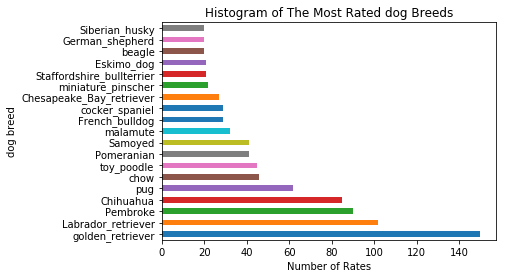

In [86]:
twitter = twitter_archive_master.groupby('dog_breed').filter(lambda x: len(x) >= 20 and len(x) <= 300)
twitter['dog_breed'].value_counts().plot(kind = 'barh')
plt.title('Histogram of The Most Rated dog Breeds')
plt.xlabel('Number of Rates')
plt.ylabel('dog breed')

#### Golden retriever is the most rated dog based on the prediction algorithm.

In [87]:
twitter['dogtionary']

1             0
2             0
3             0
5             0
7             0
9         doggo
10            0
11            0
12        puppo
13            0
14        puppo
16            0
17            0
18            0
19            0
20            0
24            0
25            0
28       pupper
30            0
32            0
33            0
34            0
36            0
37            0
38            0
39        doggo
41            0
42      floofer
43            0
         ...   
1925          0
1926          0
1928          0
1930          0
1937          0
1938          0
1941          0
1944          0
1946          0
1947          0
1948          0
1950          0
1951          0
1952          0
1954          0
1955          0
1968          0
1969          0
1974          0
1975          0
1977          0
1982          0
1985          0
1986          0
1996          0
1999          0
2001          0
2002          0
2005          0
2007          0
Name: dogtionary, Length

### Insight (2)
What's the Most Rated dog stage or dogtionary in twitter account WeRateDog?

(-1.2883414974105336,
 1.2347595059156864,
 -1.2174599441582268,
 1.2100883128691122)

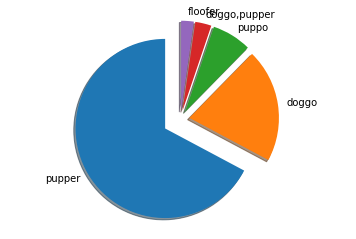

In [93]:
# Plot the data partitions by dogtionary
twitter = twitter_archive_master.groupby('dogtionary').filter(lambda x: len(x) >= 0 and len(x) <= 300)
dogtionary_count = list(twitter[twitter['dogtionary'] != 'None']['dogtionary'].value_counts())[0:5]
dogtionary = twitter[twitter['dogtionary'] != 'None']['dogtionary'].value_counts().index.tolist()[0:5]
explode = (0.2, 0.1, 0.1, 0.1, 0.1) 

fig1, ax1 = plt.subplots()
ax1.pie(dogtionary_count, explode = explode, labels = dogtionary, shadow = True, startangle = 90)
# equal ~ drawn as a circle.
ax1.axis('equal')  

#### Pupper is the most rated dogtionary or dog stage in WeRateDog twitter account

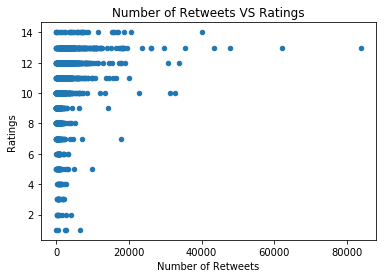

In [94]:
# Scatterplots
twitter_arch = twitter_archive_master.groupby('rating_numerator').filter(lambda x: len(x) >= 4 and len(x) <= 5000)
twitter_arch.plot(x='retweets', y='rating_numerator', kind='scatter')
plt.xlabel('Number of Retweets')
plt.ylabel('Ratings')
plt.title('Number of Retweets VS Ratings')
fig = plt.gcf()

#### Most of the tweets that got highest retweets lie in ratings between 10 and 14

#### Reports are  in Wrangle_report.html and Act_report.html